# 读取图片data

到目前为止，我们一直在使用通常不会在实际项目中使用的相当人为的数据集（table）。相反实际情况中，我们可能会处理像智能手机、相机那样的任意size尺寸图像。所以！！！！我们将看看如何加载图像并使用它们来训练神经网络。

这次用的是最可爱的🐈🐶 [dataset of cat and dog photos](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip) from Kaggle.请看图例

<img src='assets/dog_cat.png'>

我们将使用此数据集来训练可以区分猫和狗的神经网络。这些天它似乎不是一项重大成就，但五年前它对CV来说是一个严峻的挑战！！！

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch #经典的pytorch 主文件包，类比就是numpy，看都是双音节词
from torchvision import datasets, transforms

import helper

使用 `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)).是最简单的方法，一般而言`ImageFolder` 是这样用的:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

这个 `'path/to/data'` 就是data的路径 `transform` 一系列变换设定 [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) 使用的是torch视觉 `torchvision`. ImageFolder 适合处理一下结构的图片集:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

class 打头，如上所示，在根目录的第一个子目录(`cat` and `dog`)  所以这个图片 `123.png` 将会被标记为 `cat`label. 直接下载data解压即可发现 [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). 

### Transforms

我们可以用 `ImageFolder`载入图片，那可是还是图片呀！我们要的可是data，就是数字去进行机器学习呀！ 你需要定义一些变换。例如，图像的大小不同，但我们需要它们的大小都相同才能进行训练。你可以用它来调整大小 `transforms.Resize()` 或者是裁剪 `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. 我们还需要将图像转换为PyTorch张量！！ `transforms.ToTensor()`. 通常，您会将这些转换组合到一个pipeline中 `transforms.Compose()`, 通过接受一系列变换并按顺序运行它们。如下就是进行 缩放，然后裁剪，然后转换为张量:

```python
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

```

更多的变换，请查看官方 [documentation](http://pytorch.org/docs/master/torchvision/transforms.html). 

### Data Loaders

数据已产生 `ImageFolder` 我们通过使用dataloader [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader)产生一个batch 的data . 用 `DataLoader` 获取数据（接着`ImageFolder`产生的图片数据）并返回批量图像和相应的标签。可以设置各种参数，例如批量大小以及每个时期后数据是否被打乱。

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

 `dataloader` 是一个 [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). 要从中获取数据，需要循环它或将其转换为迭代器并调用 `next()`.简单的说就是不能直接print出来！

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 


In [2]:
data_dir = '/Users/marcowang/Downloads/Cat_Dog_data/train' # 要自己下载改地址哦 如果要的话！

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()]) # 一系列的变换！设定好来

dataset = datasets.ImageFolder(data_dir, #第一个放路径
                               transform=transform) # 这里放的就是我们需要处理的
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

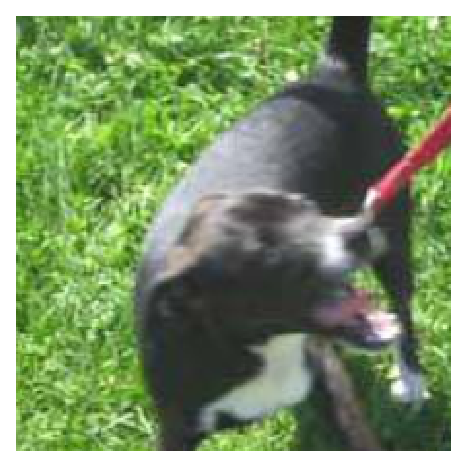

In [3]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)
# 可爱的狗子~

## Data Augmentation

训练神经网络的常用策略是在输入数据本身中引入随机性。例如，可以在训练期间随机旋转，镜像，缩放和/或裁剪图像。这将有助于网络概括，因为它看到相同的图像，但在不同的位置，不同的大小，不同的方向等。就是一套题呀，我们的model 多做几遍！

要随机旋转，缩放和裁剪，然后翻转图像，可以像这样定义变换:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

通过 `transforms.Normalize`将图像标准化！ 通过传入一个均值列表和标准偏差列表，然后将颜色通道标准化

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

使用 `mean` 将数据集中在零附近并除以“标准”，将值调整到介于-1和1之间。标准化有助于保持网络权重接近零，从而使反向传播更加稳定。如果没有规范化，NN就是个傻儿子呀。

更多请查看 [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). 但是，当进行测试时，将需要使用除标准化之外未经过更改的图像。因此，对于验证/测试图像，您通常只需调整大小和裁剪。



In [4]:
data_dir = '/Users/marcowang/Downloads/Cat_Dog_data' # 要自己下载改地址哦 如果要的话！


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225])])


# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


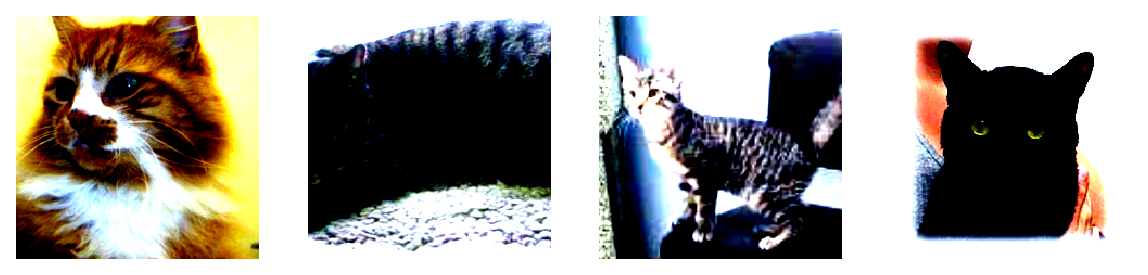

In [5]:
# change this to the trainloader or testloader 
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)

### 可将上面的normalize 去掉然后 再进行更改

### 搭个模型，看看效果

In [6]:
import torch.nn as nn
import torch.nn.functional as F
# Optional TODO: Attempt to build a network to classify cats vs dogs from this dataset
class CatDogs(nn.Module):
    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding = 1)
        self.conv2 = nn.Conv2d(16,32,3,padding = 1)
        self.conv3 = nn.Conv2d(32,64,3,padding = 1)
        self.fc1 = nn.Linear(64 * 28 * 28,1024)
        self.fc2 = nn.Linear(1024,128)
        self.fc3 = nn.Linear(128,2)
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.MaxPool2d(2,2)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x))) #112
        x = self.pool(F.relu(self.conv2(x))) #56
        x = self.pool(F.relu(self.conv3(x))) #28
        x = x.view(-1,64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc3(x),dim =1)
        
        return x
model = CatDogs()
print(model)

CatDogs(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=50176, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.3)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [7]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)


In [9]:
import numpy as np
n_epochs = 30

for epoch in range(1, n_epochs+1):

    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in trainloader:

        optimizer.zero_grad()
        
        output = model(data)
 
        loss = criterion(output, target)
        
        loss.backward()
        
        optimizer.step()
       
        train_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(trainloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))

Epoch: 1 	Training Loss: 0.114179
Epoch: 2 	Training Loss: 0.151899
Epoch: 3 	Training Loss: 0.163829
Epoch: 4 	Training Loss: 0.162437
Epoch: 5 	Training Loss: 0.159619
Epoch: 6 	Training Loss: 0.143713
Epoch: 7 	Training Loss: 0.116616
Epoch: 8 	Training Loss: 0.098173
Epoch: 9 	Training Loss: 0.085431
Epoch: 10 	Training Loss: 0.075684
Epoch: 11 	Training Loss: 0.071258
Epoch: 12 	Training Loss: 0.067918
Epoch: 13 	Training Loss: 0.063348
Epoch: 14 	Training Loss: 0.061515
Epoch: 15 	Training Loss: 0.060774
Epoch: 16 	Training Loss: 0.059352
Epoch: 17 	Training Loss: 0.057708
Epoch: 18 	Training Loss: 0.057964
Epoch: 19 	Training Loss: 0.056712
Epoch: 20 	Training Loss: 0.058571


KeyboardInterrupt: 

### 结果的test是没有label的，我们只能打印出来看看效果。这个教程，我没做validation！

In [10]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

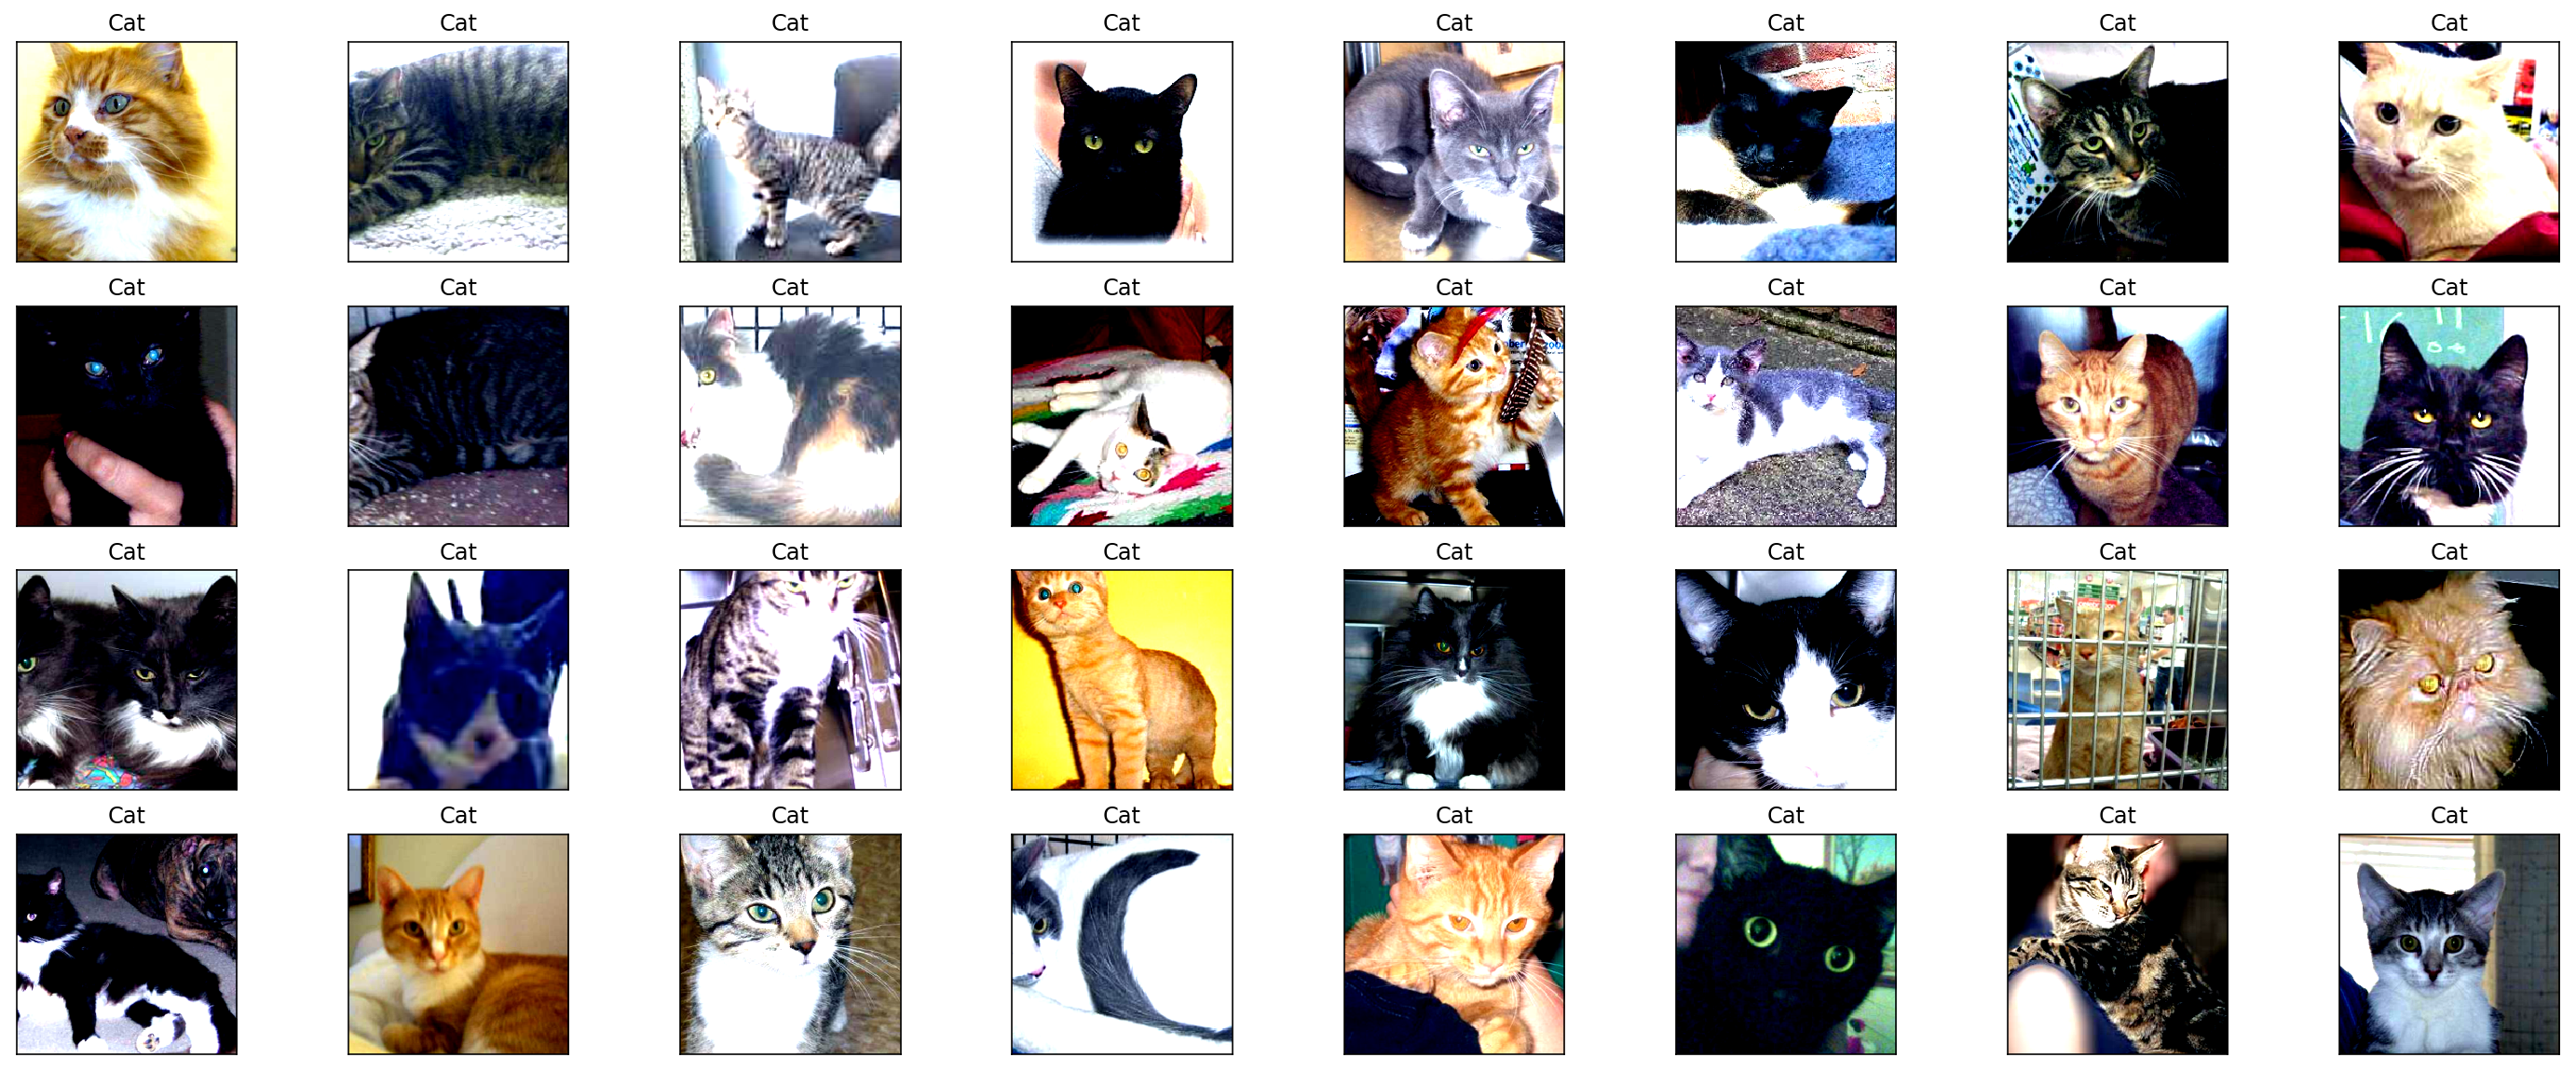

In [18]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()#我们要作图的话，不能直接用tensor


model.eval()
# 使用model 做出predict
output = model(images)

_, preds_tensor = torch.max(output, 1)
preds = preds_tensor.numpy()


class_ = ['Dog','Cat']
fig = plt.figure(figsize=(25,10))
for idx in range(32):
    ax = fig.add_subplot(4, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{}".format(class_[preds[idx]]))
    
## 一张张打印出来，然后看看结果
